In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("train.csv")
df.head()
ntrain = df.shape[0]
test = pd.read_csv("test.csv")
test.head()
ntest = df.shape[0]

In [6]:
all_data = pd.concat((df, test)).reset_index(drop=True)
all_data.drop(["SalePrice"], axis=1,inplace=True)
all_data.drop(["Id"], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [7]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071
GarageCond,5.447071


In [8]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [9]:
from scipy import stats
from scipy.stats import norm, skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.145323
EnclosedPorch,4.003891
ScreenPorch,3.946694
BsmtHalfBath,3.929996


In [10]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 37 skewed numerical features to Box Cox transform


In [11]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 288)


In [12]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [13]:
train = all_data[:ntrain]
train =pd.concat((train, df["SalePrice"]), axis=1).reset_index(drop=True)
train =pd.concat((train, df["Id"]), axis=1).reset_index(drop=True)

test1 = all_data[ntrain:]
test1 = test1.reset_index()
test1 = test1.rename(columns={"index":"Id"})
# test1 =pd.concat((test1, test["Id"]), axis=1)


In [14]:

correlation_matrix = train.corr()["SalePrice"]
high_corr_column = correlation_matrix[abs(correlation_matrix) > 0.6]

extracted_df = train[high_corr_column.index]
print(extracted_df.head())

   OverallQual  GrLivArea    TotalSF  SalePrice
0     2.440268  13.698888  14.976591     208500
1     2.259674  12.792276  14.923100     181500
2     2.440268  13.832085  15.149678     223500
3     2.440268  13.711364  14.857121     140000
4     2.602594  14.480029  15.852312     250000


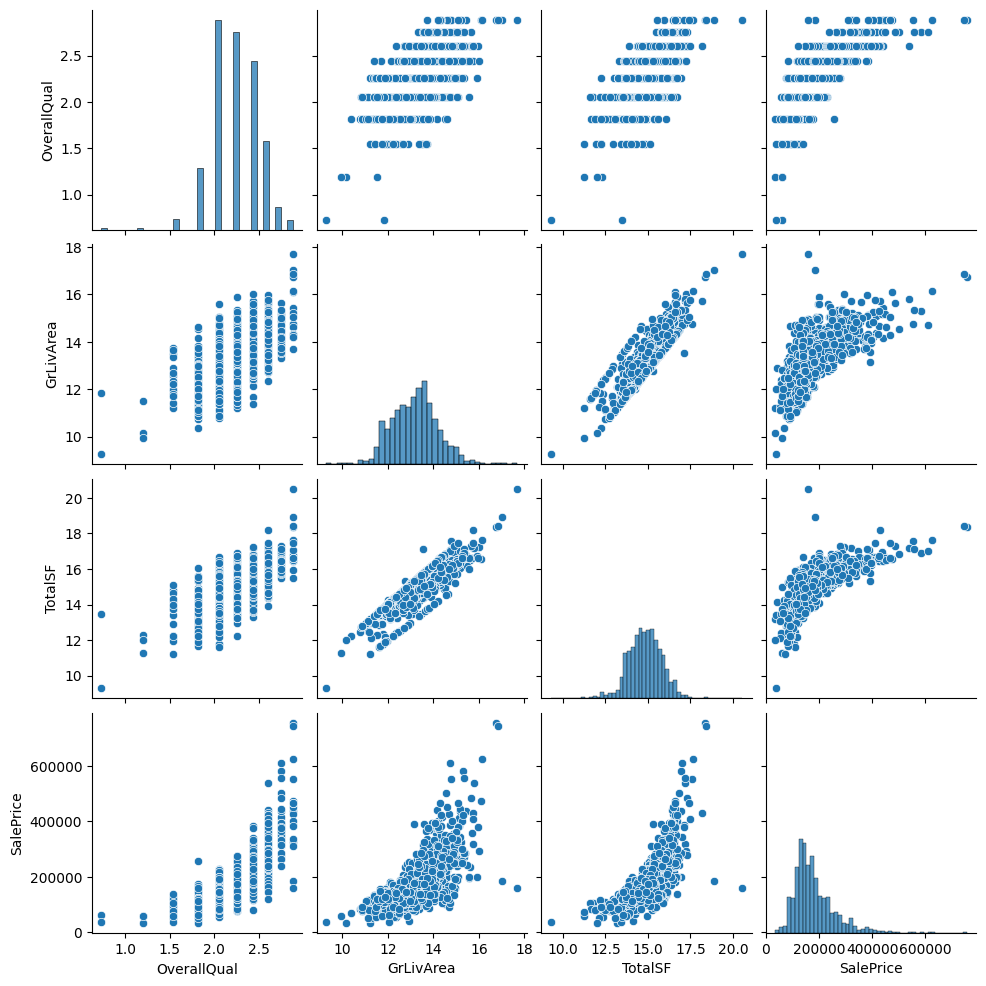

In [15]:
sns.pairplot(extracted_df)
plt.show()

In [16]:
#外れ値削除
extracted_df = extracted_df.drop(extracted_df[(extracted_df["GrLivArea"]>4000) & (extracted_df['SalePrice']>100000)].index)

In [24]:
X = extracted_df.drop("SalePrice", axis=1)
y = extracted_df["SalePrice"]

#salepriceが正規分布では、ないので対数変換する
# y = np.log1p(y)

In [25]:
from sklearn.preprocessing import StandardScaler

#normalziation
scl = StandardScaler()
std_X = scl.fit_transform(X)


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(std_X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

lin_model = RandomForestRegressor(n_estimators=100, random_state=42)
# lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_pred))
print(f"Linear Regression RMSE: {lin_rmse:.2f}")

Linear Regression RMSE: 32550.65


In [28]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
# ハイパーパラメータの設定
params = {
    'objective': 'regression',       # 回帰問題
    'metric': 'rmse',                # 評価指標
    'boosting_type': 'gbdt',         # 勾配ブースティング
    'num_leaves': 31,                # 葉の数
    'learning_rate': 0.05,           # 学習率
    'feature_fraction': 0.9          # 特徴量の使用率
}
# モデルの学習
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,   
)

# 予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 評価（RMSE）
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 3
[LightGBM] [Info] Start training from score 181441.541952
RMSE: 36212.59


In [ ]:

from tensorflow import keras
from tensorflow.keras import layers

# データの読み込み（例：Boston Housingデータ）
data = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")
X = data.drop("medv", axis=1)
y = data["medv"]

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルの構築
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # 1つ目の隠れ層
    layers.Dense(32, activation='relu'),                                   # 2つ目の隠れ層
    layers.Dense(1)                                                       # 出力層（線形活性化関数）
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# モデルの学習
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=0)

# 予測
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


In [34]:
X_val = test1[["OverallQual",  "GrLivArea",  "TotalSF"]]
scl = StandardScaler()
std_X_val = scl.fit_transform(X_val)

# lin_val_pred = np.expm1(lin_model.predict(std_X_val))
lin_val_pred = model.predict(std_X_val, num_iteration=model.best_iteration)

In [35]:
compare_result = test[["Id"]].copy()
compare_result["SalePrice"] = lin_val_pred
compare_result.head()

,Id,SalePrice
0,1461,122644.282895
1,1462,164494.437707
2,1463,157598.764514
3,1464,177363.966867
4,1465,224717.720555


In [36]:
compare_result.to_csv('submission.csv', index=False)